In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import time
import uuid

import matplotlib.pyplot as plt
import networkx as nx

from req_analysis import Requirement

## Initialize connection to Neptune

In [3]:
%run 'req_analysis/neptune-util.py'
%env NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
%env NEPTUNE_CLUSTER_PORT=8182
g = neptune.graphTraversal()

env: NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
env: NEPTUNE_CLUSTER_PORT=8182
gremlin: ws://100.65.51.106:8182/gremlin


In [4]:
from SPARQLWrapper import SPARQLWrapper, JSON, POST, DIGEST, URLENCODED

sparql = SPARQLWrapper("http://100.65.51.106:3001/sparql")
sparql.requestMethod = 'urlencoded'

In [23]:
queryString = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

# `Class` that has an `appliedStereotypeInstance` `InstanceSpecification` whose type is <<Requirement>> Stereotype (ID)
select * from mms-graph:data.tmt {
    # `Class` that has an `appliedStereotypeInstance`...
    ?class a uml-class:Class ;
        mms-property:appliedStereotypeInstance ?instance ;
        .

    # `InstanceSpecification`. Stereotype classifier and all slots
    ?instance mms-property:classifierFromInstanceSpecification ?stereotype ;
        mms-property:slot ?slot ;
        .

    # stereotype and its name, e.g., "TMT Requirement"
    ?stereotype a uml-class:Stereotype ;
        mms-property:nameString ?stereotypeName ;
        .

    # Slot --> value
    ?slot mms-property:valueValueSpecificationFromSlot ?slotValue ;
        .

    # value --> string
    ?slotValue a uml-class:LiteralString ;
        mms-property:valueString ?valueString ;
        .

    # filter string by those starting with html
    filter(regex(?valueString, \"^\\\\s*<\"))

    # values ?subject { mms-element:_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring }
}
"""

In [6]:
queryElements = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

select * from mms-graph:data.tmt {
    ?element a/rdfs:subClassOf* ?class
    {
        ?element rdfs:label ?label 
    } union {
        ?element mms-property:name ?label
    }
    
    filter(isLiteral(?label) && ?label != "")
    filter(?class = uml-class:Class || ?class = uml-class:Activity)
}
"""

## Clear output graph

In [9]:
sparql.setMethod(POST)
sparql.setQuery("""
clear graph <https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test>
""")
results = sparql.query()
print(results.response.read())

b'[\n{\n    "type" : "UpdateEvent",\n    "totalElapsedMillis" : 0,\n    "elapsedMillis" : 0,\n    "connFlush" : 0,\n    "batchResolve" : 0,\n    "whereClause" : 0,\n    "deleteClause" : 0,\n    "insertClause" : 0\n},\n{\n    "type" : "Commit",\n    "totalElapsedMillis" : 0\n}\n]'


## Load model elements in memory

In [10]:
sparql.setQuery(queryElements)

sparql.setReturnFormat(JSON)
el_results = sparql.query().convert()

In [11]:
model_elements = []
for result in el_results["results"]["bindings"]:
    model_elements.append(dict(uri=result['element']['value'], name=result['label']['value']))

In [12]:
print(len(model_elements))

3195


## Load text element(s) of interest

In [24]:
sparql.setQuery(queryString)

sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [25]:
print(len(results["results"]["bindings"]))

12492


## Matching

In [27]:
results["results"]["bindings"][0]

{'stereotype': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_b4c02e1_1422576771648_76971_83985'},
 'instance': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_46_edeec1a4-99c7-4282-848e-3ed235ccb281_asi'},
 'class': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_46_edeec1a4-99c7-4282-848e-3ed235ccb281'},
 'slot': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_46_edeec1a4-99c7-4282-848e-3ed235ccb281_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311'},
 'stereotypeName': {'type': 'literal', 'value': 'ObjectProperties'},
 'slotValue': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_46_edeec1a4-99c7-4282-848e-3ed235ccb281_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring'},
 'valueString': {'type': 'literal',
  'value': '<html><body>\n<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-0-SRD-0150]</strong> The

In [31]:
time1 = time.time()
for result in results["results"]["bindings"][0:100]:
#     if str.startswith(result["str"]["value"], "<html>"):
    req_object = Requirement(result["instance"]["value"], result["valueString"]["value"])
    matches, c = req_object.match_req_tokens(model_elements, 0.0035)
    if len(matches)>2:
        print('Req ID: ', result["instance"]["value"], '\nReq text:' , (result["valueString"]["value"]))
        print(matches, '\n___________')
        print(c, 'comparaisons')
        print('Time: ', time.time()-time1)
        break

Req ID:  https://opencae.jpl.nasa.gov/mms/rdf/element/_282_7052c0d8-8b2a-4300-80f2-703036bb5bba_asi 
Req text: <html><body>
<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-0-SRD-1105]</strong> 2.05x 2.05 arcmin square unvignetted field of view with AO correction by NFIRAOS. The MOSFIRE field of view is 2.26 arcmin diameter</span></body></html>
[{'token': {'text': 'NFIRAOS', 'pos': 'PROPN', 'token_id': 10}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_4663af6e-6265-438d-87b8-74e1550518bf__6294_1bb99b95-70db-4c36-9107-8ba25cd37cb7', 'name': 'NFIRAOS'}, 'score': 0.0}, {'token': {'text': 'NFIRAOS', 'pos': 'PROPN', 'token_id': 10}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_5_3_e64033a_1517517389325_390809_22791', 'name': 'NFIRAOS'}, 'score': 0.0}, {'token': {'text': 'NFIRAOS', 'pos': 'PROPN', 'token_id': 10}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_5_3_e64033a_1517948168694_886488_19869', 

In [ ]:
g = neptune.graphTraversal()
req_object.init_match_subgraph(g)

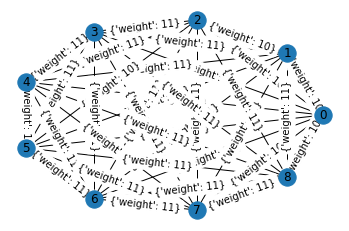

In [25]:
pos = nx.circular_layout(req_object.req_subgraph)
nx.draw_networkx_edge_labels(req_object.req_subgraph, pos)
nx.draw_circular(req_object.req_subgraph, with_labels=True)

In [26]:
req_object.req_subgraph.nodes(data=True)

NodeDataView({0: {'token': {'text': 'Executive Software', 'pos': 'PROPN', 'token_id': 124}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999', 'name': 'Executive Software'}, 'score': 0.0}, 1: {'token': {'text': 'network', 'pos': 'PROPN', 'token_id': 141}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008', 'name': 'Network'}, 'score': 0.0}, 2: {'token': {'text': 'networking', 'pos': 'NOUN', 'token_id': 144}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749', 'name': 'Networking'}, 'score': 0.0}, 3: {'token': {'text': 'components', 'pos': 'NOUN', 'token_id': 145}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1454211387743_712600_224076', 'name': 'Component'}, 'score': 0.050000000000000044}, 4: {'token': {'text': 'enclosures', 'pos': 'NOUN',

In [27]:
winners = req_object.match_clustering()

for winner in winners.values():
    print('Token: ', winner['token']['text'])
    print('Element: ', winner['model_element']['name'])
    print('URI: ', winner['model_element']['uri'], '\n_________')

Token:  Executive Software
Element:  Executive Software
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
_________
Token:  enclosures
Element:  Enclosure
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_f1d0357_1490143302007_461579_179266 
_________
Token:  network
Element:  Network
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008 
_________
Token:  networking
Element:  Networking
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749 
_________
Token:  components
Element:  Component
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1454211387743_712600_224076 
_________


In [28]:
winners

{124: {'token': {'text': 'Executive Software',
   'pos': 'PROPN',
   'token_id': 124},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999',
   'name': 'Executive Software'},
  'score': 0.0},
 156: {'token': {'text': 'enclosures', 'pos': 'NOUN', 'token_id': 156},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_f1d0357_1490143302007_461579_179266',
   'name': 'Enclosure'},
  'score': 0.050000000000000044},
 141: {'token': {'text': 'network', 'pos': 'PROPN', 'token_id': 141},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008',
   'name': 'Network'},
  'score': 0.0},
 144: {'token': {'text': 'networking', 'pos': 'NOUN', 'token_id': 144},
  'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749',
   'name': 'Networking'},
  'score': 0.0},
 145: {'token': {'

In [ ]:
insert_blocks = """
<{input_uri}> mms-autocref:reference mms-autocref-i:Reference.{reference_uuid} ;
  .

mms-autocref-i:Reference.{reference_uuid}
  a mms-autocref:Reference ;
  mms-autocref:inputText \"\"\"{input_text}\"\"\" ;
  mms-autocref:match <{match_uri}> ;
  mms-autocref:token mms-autocref-i:Token.{reference_uuid} ;
  .

mms-autocref-i:Token.{reference_uuid}
  a mms-autocref:Token ;
  mms-autocref:tokenStart "{token_position}"^^xsd:integer ;
  mms-autocref:tokenText \"\"\"{token_text}\"\"\" ;
  .
"""

In [ ]:
insert_query = """
prefix mms-autocref: <https://opencae.jpl.nasa.gov/mms/rdf/autocref/>
prefix mms-autocref-i: <https://opencae.jpl.nasa.gov/mms/rdf/autocref-instance/>

insert data {{
  graph <https://opencae.jpl.nasa.gov/mms/rdf/graph/autocref.tmt.test> {{
    {insert_blocks}
  }}
}}"""

In [ ]:
insert_concat = ""

for winner in winners.values():
    insert_concat += insert_blocks.format(input_uri = req_object.text_uri,
                                  input_text = req_object.text.replace('"', r'\"'),
                                  reference_uuid = uuid.uuid4().hex,
                                  match_uri = winner['model_element']['uri'],
                                  token_position = winner['token']['token_id'],
                                  token_text = winner['token']['text'].replace('"', r'\"'))

# print(insert_concat)
insert = insert_query.format(insert_blocks=insert_concat)
print(insert)

In [ ]:
sparql.setMethod(POST)
sparql.setQuery(insert)


results = sparql.query()
print(results.response.read())

# MISCELLANEOUS 

In [ ]:
req_object.match_clustering_stop_condition()

In [ ]:
D = [[ 0.,  2.,  3. , 2.],
 [ 3. , 6.,  5.,  3.],
 [ 4. , 5.,  9.,  2.],
 [ 1. , 7., 11.,  4.],
 [ 8. , 9., 11.,  6.]]

In [ ]:
from paris.utils import select_clustering, select_clustering_gen, select_clustering_gen2

In [ ]:
# print(select_clustering_gen2(D, req_object.req_subgraph, 0))
# print(select_clustering_gen2(D, req_object.req_subgraph, 1))
# print(select_clustering_gen2(D, req_object.req_subgraph, 2))
# print(select_clustering_gen2(D, req_object.req_subgraph, 3))
# print(select_clustering_gen2(D, req_object.req_subgraph, 4))
print(select_clustering_gen2(D, req_object.req_subgraph, 5))

In [94]:
summit='_4663af6e-6265-438d-87b8-74e1550518bf__65_6314a138-53b9-42a5-b488-9c23967ed889'
enclosure='_18_0_6_f1d0357_1490143302007_461579_179266'
mirror='_18_5_2_e64033a_1509475358071_810923_58742'
aps_user='_17_0_2_3_41e01aa_1389730769202_855584_72742'
aps_mission='_17_0_2_3_41e01aa_1389728637481_651557_61606'
usr_part_aps_mission='_17_0_2_3_41e01aa_1389731842407_88153_73842'
value_aps_mission='_18_0_2_baa02e2_1421376436201_767368_80540'

In [107]:
g = neptune.graphTraversal()
g.V('_18_0_2_b4c02e1_1443121772933_102673_179684').repeat(both().simplePath()).until(hasId('_18_0_2_b4c02e1_1443121772933_102673_179684_asi').or_().loops().is_(8)).path().limit(1).toList()

gremlin: ws://100.65.51.106:8182/gremlin


[path[v[_18_0_2_b4c02e1_1443121772933_102673_179684], v[_18_0_2_b4c02e1_1443121772933_102673_179684_asi]]]

In [108]:
g.V('_17_0_2_3_41e01aa_1389728637481_651557_61606').out('ownedAttributeFromClass').out().hasLabel('Class').valueMap().toList()

[{'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Mission']},
 {'_label': ['APS Operational Blackbox Specification JPL']},
 {'_label': ['M1 Control System']},
 {'_label': ['APS User']},
 {'_label': ['Executive Software']},
 {'_label': ['Common Services']},
 {'_label': ['Telescope Control System']}]

In [ ]:
_17_0_2_3_41e01aa_1389728637481_651557_61606,_18_0_2_baa02e2_1421376436201_767368_80540

In [47]:
g = neptune.graphTraversal()
g.V('_17_0_2_3_41e01aa_1383543404575_236284_66843').repeat(both().simplePath()).until(hasId('_17_0_2_3_41e01aa_1383543404576_569689_66846').or_().loops().is_(8)).path().limit(1).toList()

gremlin: ws://100.65.51.106:8182/gremlin


[path[v[_17_0_2_3_41e01aa_1383543404575_236284_66843], v[_17_0_2_3_41e01aa_1383543404576_569689_66846]]]

In [51]:
g.V(aps_mission).repeat(out('ownerElement')).emit().as_('x').repeat(__.in_('ownerElement')).emit(hasId(usr_part_aps_mission)).select('x').limit(1).toList()

[v[_18_0_2_baa02e2_1421374196576_95730_78327]]

In [49]:
g.V(aps_mission).both().toList()

[v[_17_0_2_3_41e01aa_1389728637481_651557_61606_asi],
 v[_17_0_2_3_41e01aa_1389728637481_651557_61606_asi],
 v[_18_0_2_baa02e2_1421374196576_95730_78327],
 v[_17_0_2_3_41e01aa_1389729306878_38075_62969],
 v[_17_0_2_3_41e01aa_1389729306878_38075_62969],
 v[_17_0_2_3_41e01aa_1389731842407_88153_73842],
 v[_17_0_2_3_41e01aa_1389731842407_88153_73842],
 v[_17_0_2_3_41e01aa_1392143906001_327948_74735],
 v[_17_0_2_3_41e01aa_1392143906001_327948_74735],
 v[_17_0_2_3_41e01aa_1392143851234_419249_74564],
 v[_17_0_2_3_41e01aa_1392143851234_419249_74564],
 v[_18_0_2_baa02e2_1421376436201_767368_80540],
 v[_18_0_2_baa02e2_1421376436201_767368_80540],
 v[_17_0_2_3_41e01aa_1392141049983_161762_73149],
 v[_17_0_2_3_41e01aa_1392141049983_161762_73149],
 v[_18_0_5_baa02e2_1450822437908_614610_154553],
 v[_18_0_5_baa02e2_1450822437908_614610_154553],
 v[_17_0_2_3_41e01aa_1389730627603_980584_72643],
 v[_17_0_2_3_41e01aa_1389730627603_980584_72643],
 v[_18_0_4_baa02e2_1438799229720_161594_151777],
 v[_18

In [ ]:
g = neptune.graphTraversal()
g.V(enclosure).valueMap().toList()

In [ ]:
import spacy

nlp_np = spacy.load("en_core_web_sm")
merge_nps = nlp_np.create_pipe("merge_noun_chunks")
nlp_np.add_pipe(merge_nps)


In [ ]:
for t in nlp_np("Hello my name is the beautiful car of New York. Bye!"):
    print(t.text, t.pos_, t.idx)

In [ ]:
def node_distance(neptune_instance, el_1, el_2):
    try:
        with time_limit(3):
            path = neptune_instance.V(el_1).repeat(both().not_(hasId('master')).simplePath()).until(hasId(el_2).or_().loops().is_(8)).path().limit(1).toList()[0]
            if (path[0].id == el_1) and (path[-1].id == el_2):
                return len(path)-1
            else:
                return 10
    except TimeoutException as e:
        print("Timeout")
        return 10
    
        

In [ ]:
g = neptune.graphTraversal()
node_distance(g, aps_user, summit)